In [1]:
!pip install bayesian-optimization
!pip install scikit-optimize

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=dda9fb2b995fe075dc264bade3593094e0ca9fc9c92ea30d7d0dcb3c60defbfe
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 100 kB 9.3 MB/s 


##### Imports

In [2]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import warnings

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV 

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools

##### Reading DBs

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

dftrain=pd.read_csv('gdrive/My Drive/credimi/train.csv',delimiter="|")
test=pd.read_csv('gdrive/My Drive/credimi/test.csv',delimiter="|")

Mounted at /content/gdrive


In [4]:
test = test.drop(["sfid","dt_rif"],axis=1)

In [5]:
target = "target"
catCols = [x for x in dftrain.columns if (is_string_dtype(dftrain[x]) & (x!="dt_rif") & (x!="sfid")) ]
numCols = [x for x in dftrain.columns if (is_numeric_dtype(dftrain[x])) & (x!="target")]

In [6]:
X = dftrain[catCols+numCols]
y = dftrain[target]

In [7]:
for c in catCols:
  test = test.astype({c:"category"})
for c in catCols:
  X = X.astype({c:"category"})

##### Custom metric definition and printing results utils

In [27]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def MoneyScore(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (3*tn - (3*fp) - (50*fn))*1000

def credimiScoring(y_true,y_pred):
    y_pred = [0  if x<0.2 else 1 for x in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("True Negative: "+str(+3*tn*1000))
    print("False Positive: "+str(-3*fp*1000))
    print("False Negative: "+str(-50*fn*1000))
    print("Total score: "+str(MoneyScore(y_true,y_pred)))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ['0', '1'],)

In [28]:
# Could create a mechanism to find the best threshold
def credimiMetric(preds: np.ndarray, data: lgb.Dataset, threshold: float=0.2):
    label = data.get_label()
    pred_label = (preds > threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(label, pred_label).ravel()

    num_zeros = (label == 0).sum()
    num_ones = (label == 1).sum()
    
    worst = (-3*num_zeros) + (-50*num_ones)
    best = (3*num_zeros)

    score = (((3*tn) - (3*fp) - (50*fn)) - worst) / (best - worst)
    
    return 'credimi', score, True

##### Bayesian Hyperparam optimization

In [29]:
# Source https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm/notebook

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
  train_data = lgb.Dataset(data=X, label=y, free_raw_data=False,categorical_feature=catCols,)

  def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
    params = {'application':'binary', 'metric':'auc',"is_unbalanced":True}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)
        
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=None,feval=credimiMetric)
    return max(cv_result['credimi-mean'])
     
  lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                          'num_leaves': (24, 80),
                                          'feature_fraction': (0.1, 0.9),
                                          'bagging_fraction': (0.8, 1),
                                          'max_depth': (5, 30),
                                          'max_bin':(20,90),
                                          'min_data_in_leaf': (20, 80),
                                          'min_sum_hessian_in_leaf':(0,100),
                                          'subsample': (0.01, 1.0)}, random_state=200)

    
  lgbBO.maximize(init_points=init_round, n_iter=opt_round)
  
  model_auc=[]
  for model in range(len( lgbBO.res)):
      model_auc.append(lgbBO.res[model]['target'])
  
  # return best parameters
  return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # init_round=50, opt_round=50 during actual testing 
    opt_params = bayes_parameter_opt_lgb(X, y, init_round=50, opt_round=50, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8199   |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.7931   |  0.9964   |  0.7939   |  0.9862   |  84.63    |  12.59    |  70.77    |  12.12    |  67.99    |  0.258    |
|  3        |  0.8102   |  0.8192   |  0.8548   |  0.8278   |  56.28    |  26.84    |  54.7     |  45.01    |  62.09    |  0.4252   |
|  4        |  0.827    |  0.9281   |  0.5869   |  0.1144   |  87.62    |  23.97    |  60.78    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.811    |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |
|  6        |  0.8132   |  0.8342   |  0.8825   |  0.3083   | 

In [30]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params[1]["metric"] = None
found_opt_params=opt_params[1]
found_opt_params

{'bagging_fraction': 0.8773888983810538,
 'boost_from_average': False,
 'feature_fraction': 0.7610913709177939,
 'is_unbalance': True,
 'learning_rate': 0.11431478403733293,
 'max_bin': 22,
 'max_depth': 24,
 'metric': None,
 'min_data_in_leaf': 73,
 'min_sum_hessian_in_leaf': 5.445503374547966,
 'num_leaves': 47,
 'objective': 'binary',
 'subsample': 0.09516083782499006}

##### Model Evaluation

Fold 0
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.192561	training's credimi: 0.899032	valid_1's binary_logloss: 0.25151	valid_1's credimi: 0.852703
Fold 1
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.190199	training's credimi: 0.901369	valid_1's binary_logloss: 0.296538	valid_1's credimi: 0.829289
Fold 2
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.122837	training's credimi: 0.938895	valid_1's binary_logloss: 0.254617	valid_1's credimi: 0.827799
Fold 3
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0318787	training's credimi: 0.991079	valid_1's binary_logloss: 0.186177	valid_1's credimi: 0.894636
Fold 4
Training until validation scores don't i

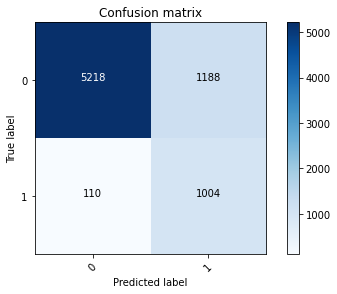

None


In [31]:
# Source https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm/notebook

target=y
features= catCols+numCols

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(X))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(found_opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250,feval=credimiMetric)
    oof[val_idx] = clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

  print(credimiScoring(target, oof))

##### Feature importance graph

In [ ]:
# Source https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm/notebook

cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

##### Creating Submission

In [ ]:
testId=pd.read_csv('gdrive/My Drive/credimi/test.csv',delimiter="|")
sol = pd.concat([testId["sfid"],pd.DataFrame([0  if x<0.05 else 1 for x in predictions] )],axis=1)
sol = sol.set_index("sfid")
sol.columns=["label"]
sol.to_csv("final.csv")

with open('final.csv', 'r+') as f:
  content = f.read()
  f.seek(0)
  f.truncate()
  f.write(content.replace(',', '|'))